In [1]:
import itertools
import collections

import numpy as np
import astropy.units as u

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')  # noqa: E402
seaborn.set_context("poster")  # noqa: E402

import lsst.daf.persistence
import lsst.meas.astrom
import lsst.afw.table
from lsst.validate.drp.util import positionRmsFromCat, averageRaDecFromCat

In [2]:
# switch this for use on lsst-dev
# datadir = '/Users/parejkoj/lsst/jointcal/jointcal/tests/.test/JointcalTestCFHT/test_jointcalTask_2_visits_constrainedAstrometry_no_photometry'
# tract = 0
# visits = [849375, 850587]
# ccds = [12, 13, 14, 21, 22, 23]

# Using: WIDE_8524_HSC-I
datadir = '/project/parejkoj/hscRerun/DM-15713/WIDE'
tract = 8524
visits = [7286, 7288, 7290, 7292, 7298, 7300, 7302, 7304, 7310, 7338, 7340, 7350, 7352, 7356, 7358, 7364, 7366, 7370, 7372, 7378, 7384, 7386, 7390, 7392, 7394, 7396, 7400, 7402, 7416, 14124, 14126, 14128, 14130, 14142, 14144, 14146, 14164, 14166, 14176, 14178, 14196, 14198, 14206, 14208, 14210, 1623]  # noqa
ccds = list(range(1, 103))
filt = 'HSC-I'
ccds.remove(9)  # ccd 9 is bad
ccds = np.array(ccds)

butler = lsst.daf.persistence.Butler(datadir)

## using multimatch

In [18]:
def filter_matches(allMatches, fluxField):
    """Filter down to matches with at least 2 sources and good flags."""
    flagKeys = [allMatches.schema.find("base_PixelFlags_flag_%s" % flag).key
                for flag in ("saturated", "cr", "bad", "edge")]
    nMatchesRequired = 2

    fluxSnrKey = allMatches.schema.find(fluxField + "_snr").key
    # NOTE: alias oddities mean I have to change "_flux" <-> "_instFlux" depending on catalog version.
    fluxKey = allMatches.schema.find(fluxField + "_flux").key
    extendedKey = allMatches.schema.find("base_ClassificationExtendedness_value").key

    def goodFilter(cat, goodSnr=3):
        if len(cat) < nMatchesRequired:
            return False
        for flagKey in flagKeys:
            if cat.get(flagKey).any():
                return False
        if not (cat.get(fluxKey) > 0).all():
            return False
        psfSnr = np.median(cat.get(fluxSnrKey))
        # Note that this also implicitly checks for psfSnr being non-nan.
        return psfSnr >= goodSnr

    return allMatches.where(goodFilter)

In [19]:
def prep_matching(butler, visits, ccds):
    dataId = dict(visit=visits[0], ccd=ccds[0], tract=tract)
    catalog = butler.get('src', dataId=dataId)
    bbox = butler.get('calexp_bbox', dataId=dataId)
    oldSchema = catalog.schema
    fluxField = oldSchema.getAliasMap().get("slot_CalibFlux")

    # make the new schema, with a field for S/N
    mapper = lsst.afw.table.SchemaMapper(oldSchema)
    mapper.addMinimalSchema(oldSchema)
    mapper.addOutputField(lsst.afw.table.Field[float](fluxField + '_snr', 'flux SNR'))
    newSchema = mapper.getOutputSchema()
    newSchema.setAliasMap(oldSchema.getAliasMap())

    multiMatch = lsst.afw.table.MultiMatch(newSchema, {"visit":np.int32, "ccd":np.int32, 'tract':np.int32})
    return bbox, fluxField, newSchema, mapper, multiMatch

In [20]:
def do_match(multiMatch, butler, visits, ccds, fluxField, newSchema, mapper, useJointcal=False):
    """Make the multiMatch, identify good matches, and compute aggregate statistics."""
    for visit, ccd in itertools.product(visits, ccds):
        dataId = dict(visit=visit, ccd=ccd, tract=tract)
        oldCat = butler.get('src', dataId=dataId)
        if useJointcal:
            wcs = butler.get('jointcal_wcs', dataId=dataId)
            lsst.afw.table.updateSourceCoords(wcs, oldCat)

        catalog = lsst.afw.table.SourceCatalog(newSchema)
        tmpCat = lsst.afw.table.SourceCatalog(lsst.afw.table.SourceCatalog(newSchema).table)
        tmpCat.extend(oldCat, mapper=mapper)
        tmpCat[fluxField + '_snr'][:] = tmpCat[fluxField + '_instFlux'] / tmpCat[fluxField + '_instFluxErr']
        catalog.extend(tmpCat, False)

        multiMatch.add(catalog, dataId=dataId)

    matchCat = multiMatch.finish()
    allMatches = lsst.afw.table.GroupView.build(matchCat)
    print("Found matches, groups:", len(matchCat), len(allMatches))

    goodMatches = filter_matches(allMatches, fluxField)
    print("Good groups:", len(goodMatches))

    averageCoord = goodMatches.aggregate(averageRaDecFromCat, dtype=[('ra', np.float64), ('dec', np.float64)]) 
    distance = goodMatches.aggregate(positionRmsFromCat) * u.milliarcsecond
    return goodMatches, averageCoord, distance

In [21]:
def count_ccds(goodMatches):
    # count how many objects are on each ccd
    counts = collections.defaultdict(int)
    for group in goodMatches.groups:
        for x in group:
            counts[x['ccd']] += 1
    print("ccd counts:", ', '.join("%s: %s"%(k,v) for k, v in counts.items()))
    return counts

In [22]:
def compute_errors(counts, goodMatches, averageCoord, ccd):
    xx = np.zeros(counts[ccd])
    yy = np.zeros(counts[ccd])
    uu = np.zeros(counts[ccd])
    vv = np.zeros(counts[ccd])
    centroid = 'base_SdssCentroid_'
    i = 0
    for group, coord in zip(goodMatches.groups, averageCoord):
        good = group['ccd'] == ccd
        n = good.sum()
#         print(n, group['ccd'], group[good]['ccd'])
        xx[i:i + n] = group[good][centroid+'x']
        yy[i:i + n] = group[good][centroid+'y']
        uu[i:i + n] = group[good]['coord_ra'] - coord[0]
        vv[i:i + n] = group[good]['coord_dec'] - coord[1]
        i += n
    uu = (uu*u.radian).to_value(u.milliarcsecond)
    vv = (vv*u.radian).to_value(u.milliarcsecond)
    return xx, yy, uu, vv

In [23]:
def uv_mean(bbox, xx, yy, uu, vv):
    nx = 10
    ny = 20
    uMean = np.zeros((nx-1, ny-1))
    vMean = np.zeros((nx-1, ny-1))
    xMean = np.zeros((nx-1, ny-1))
    yMean = np.zeros((nx-1, ny-1))
    ww = np.linspace(0, bbox.getWidth(), nx)
    hh = np.linspace(0, bbox.getHeight(), ny)
    for i, (w0, w1) in enumerate(zip(ww[:-1], ww[1:])):
        inx = (xx >= w0) & (xx <= w1)
        for j, (h0, h1) in enumerate(zip(hh[:-1], hh[1:])):
            iny = (yy >= h0) & (yy <= h1)
            inside = inx&iny
            xMean[i, j] = (w0 + w1)/2
            yMean[i, j] = (h0 + h1)/2
            uMean[i, j] = np.mean(uu[inside])
            vMean[i, j] = np.mean(vv[inside])

    return xMean, yMean, uMean, vMean

In [48]:
def plot_quiver(xx, yy, uu, vv, ccd, label):
    """Make a quiver plot of the astrometry error vectors."""
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    color = cycle[0] if 'jointcal' in label else cycle[1]
    scale = 0.2 if 'mean' in label else 1

    fig = plt.figure(figsize=(6,10))
    ax = fig.add_subplot(111)

    Q = ax.quiver(xx, yy, uu, vv, units='x', pivot='tail', scale=scale, width=7,
                  headwidth=4, clip_on=False, color=color)
    length = 5/scale if 'mean' in label else 100
    ax.quiverkey(Q, 0.85, 0.90, length, '%s mas'%(length), angle=45,
                 coordinates='figure', labelpos='W', fontproperties={'size':24})

    plt.title('ccd: {}   '.format(ccd))
    filename = "quiver-%s-%s.png"%(ccd, label)
    plt.savefig(filename, bbox_inches="tight")

In [54]:
bbox, fluxField, newSchema, mapper, multiMatch = prep_matching(butler, visits, ccds)
goodMatches, averageCoord, distance = do_match(multiMatch, butler, visits, ccds, fluxField, newSchema, mapper)
counts = count_ccds(goodMatches)

Found matches, groups: 19967 14599
Good groups: 4501
ccd counts: 12: 1390, 21: 1576, 13: 1551, 22: 1549, 14: 1399, 23: 1537


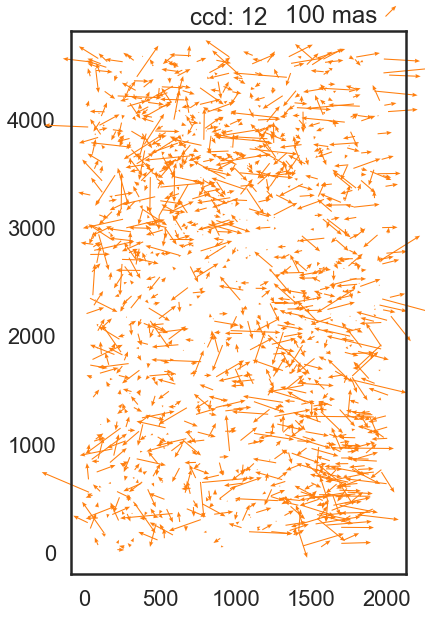

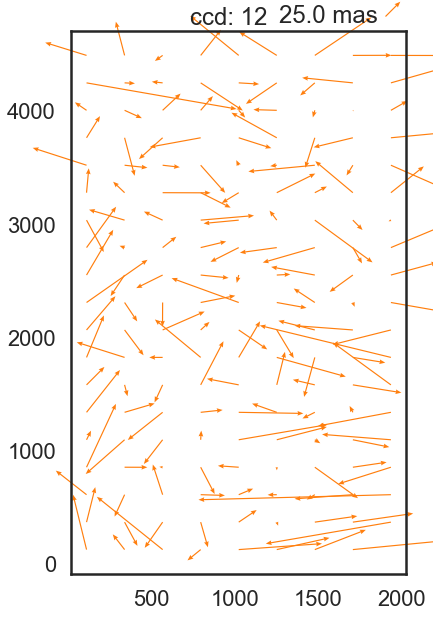

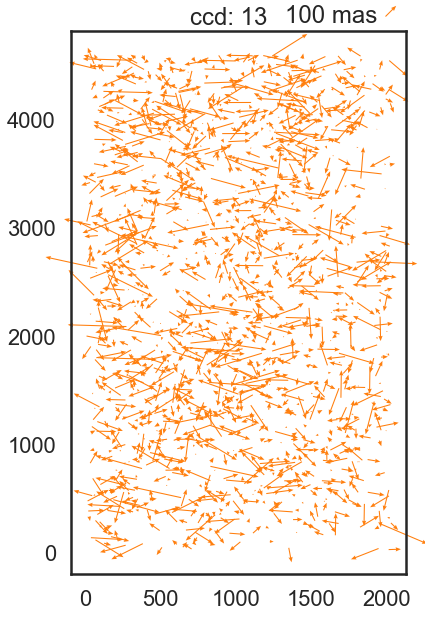

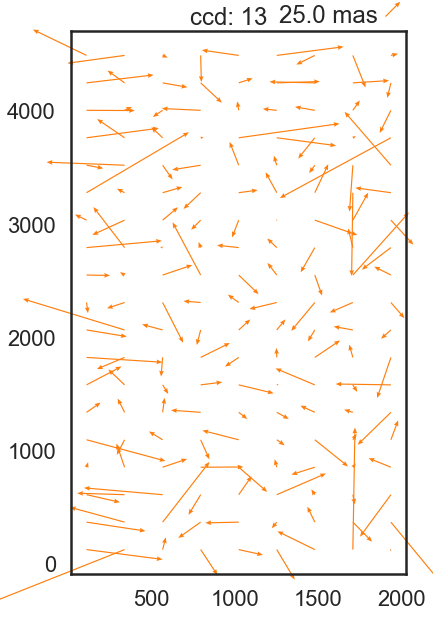

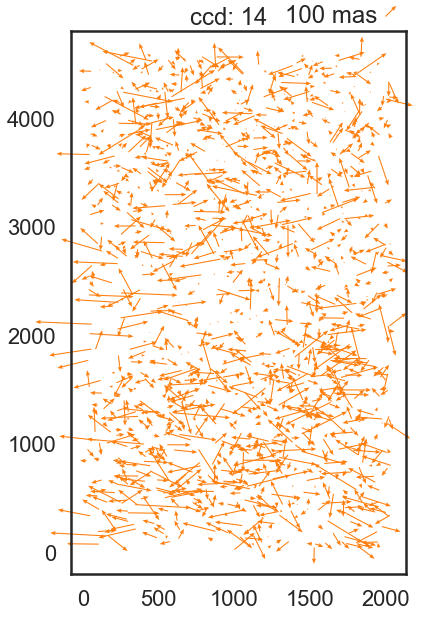

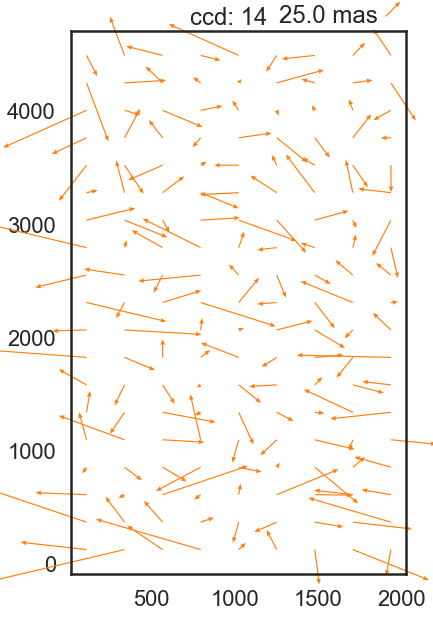

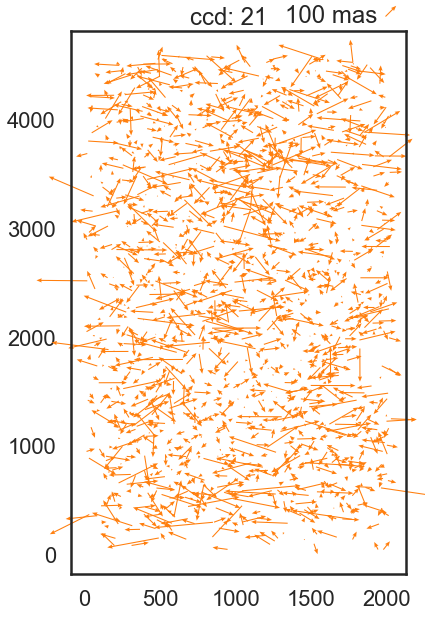

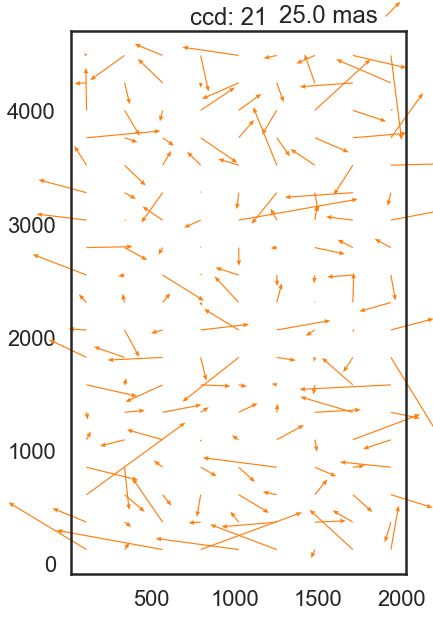

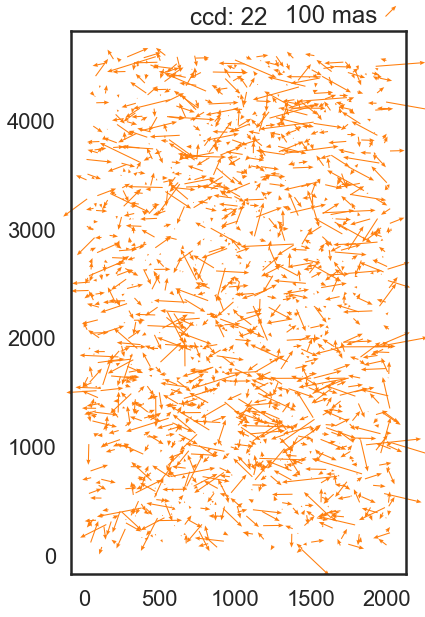

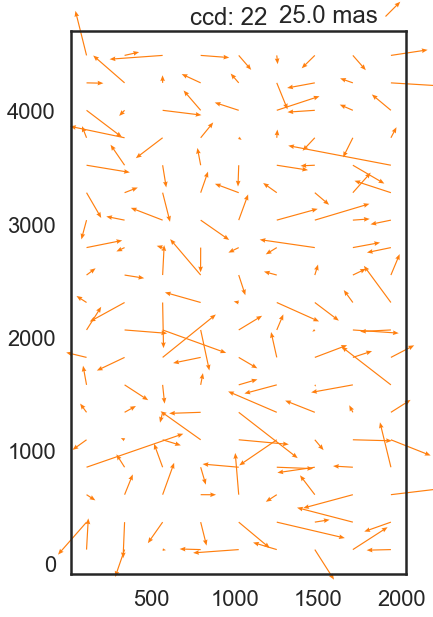

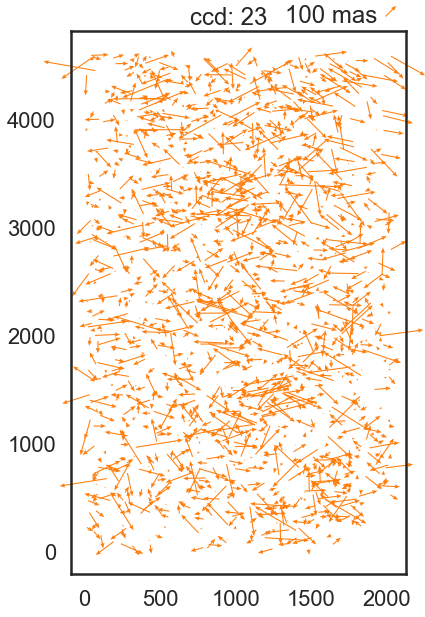

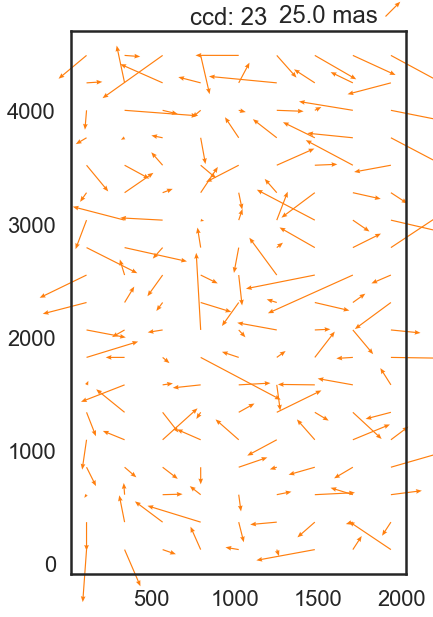

In [55]:
for ccd in ccds:
    xx, yy, uu, vv = compute_errors(counts, goodMatches, averageCoord, ccd)
    plot_quiver(xx, yy, uu, vv, ccd, 'all-single')
    xMean, yMean, uMean, vMean = uv_mean(bbox, xx, yy, uu, vv)
    plot_quiver(xMean, yMean, uMean, vMean, ccd, 'mean-single')

In [56]:
bbox, fluxField, newSchema, mapper, multiMatch = prep_matching(butler, visits, ccds)
goodMatches, averageCoord, distance = do_match(multiMatch, butler, visits, ccds, fluxField, newSchema, mapper, useJointcal=True)
counts = count_ccds(goodMatches)

Found matches, groups: 19964 14595
Good groups: 4501
ccd counts: 12: 1380, 21: 1586, 13: 1552, 22: 1558, 14: 1393, 23: 1533


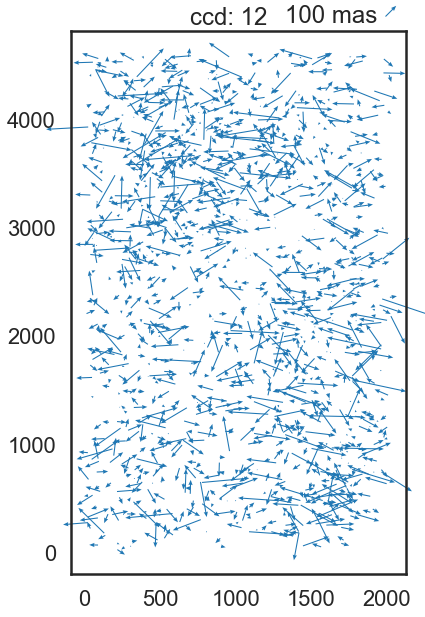

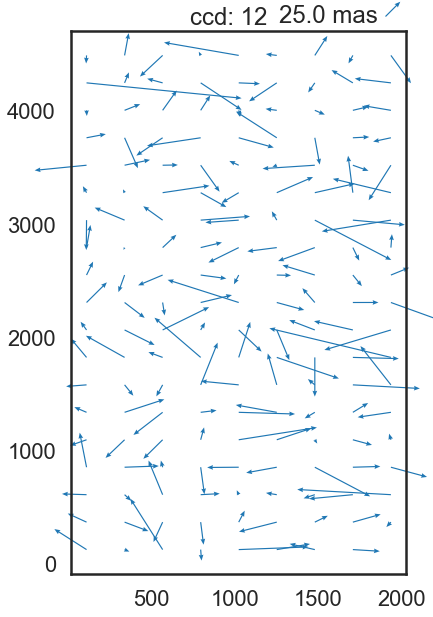

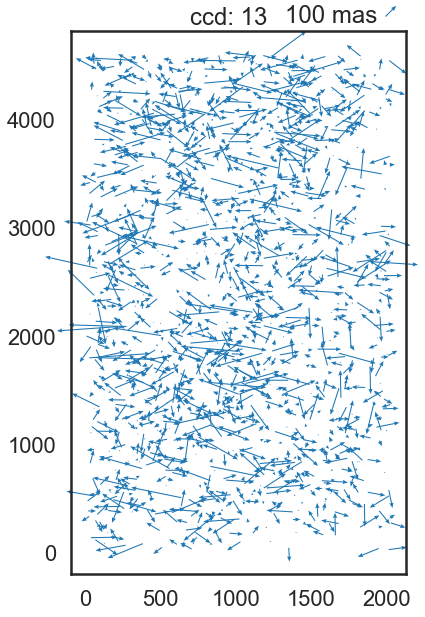

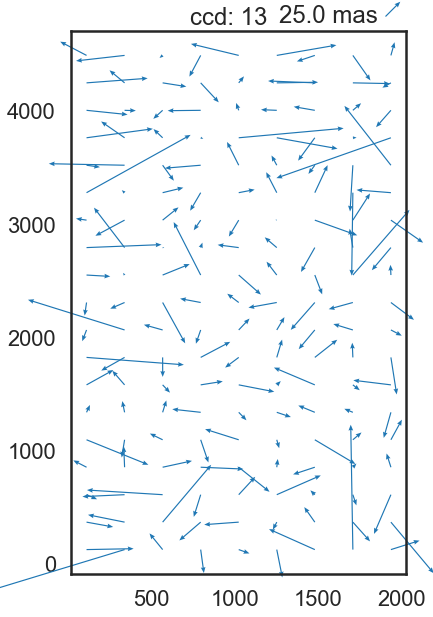

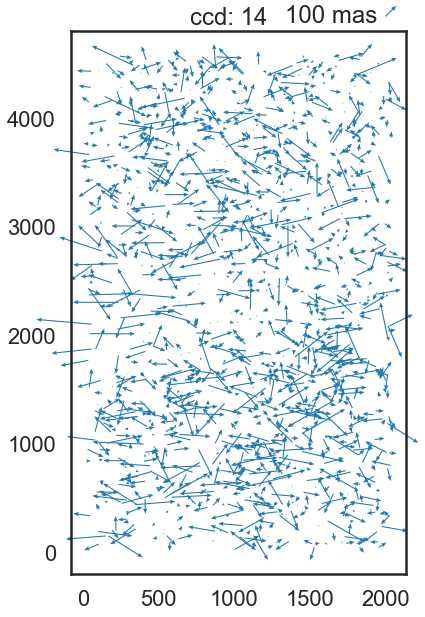

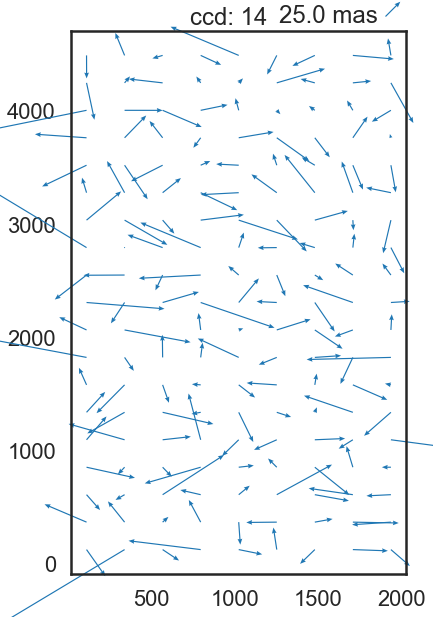

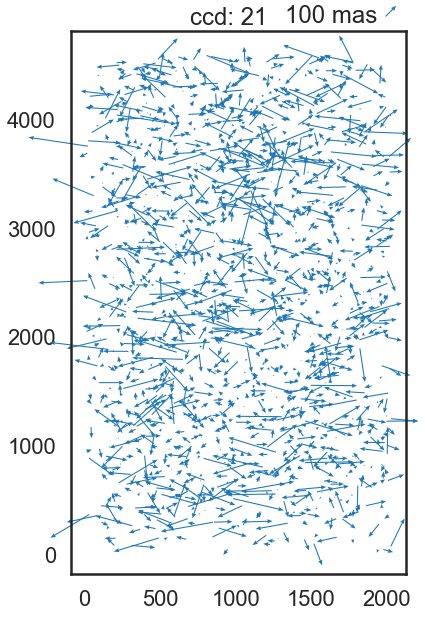

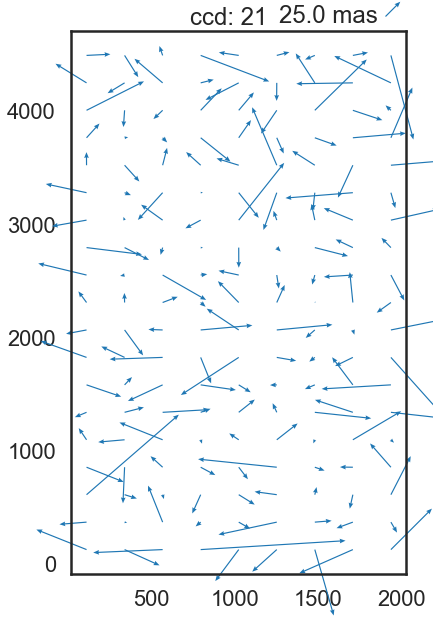

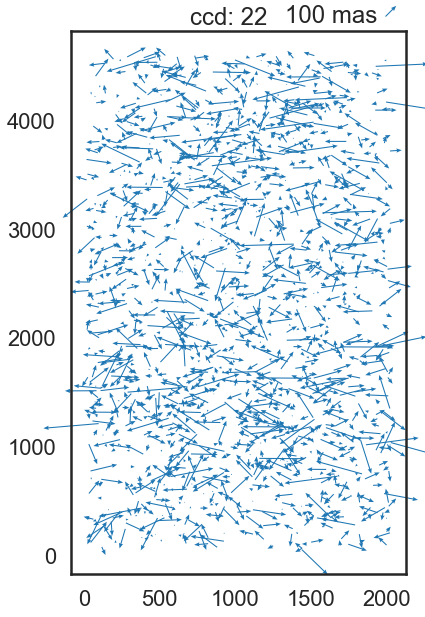

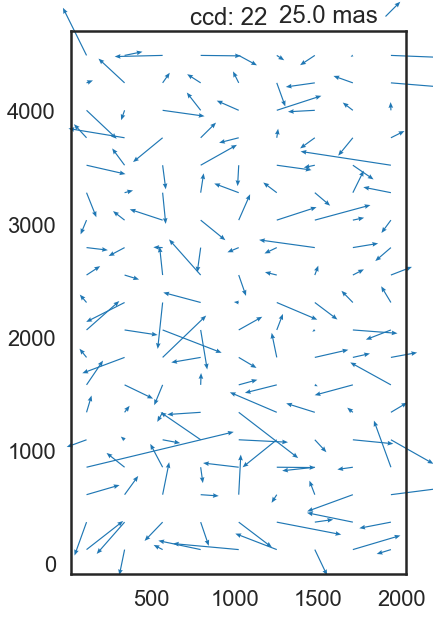

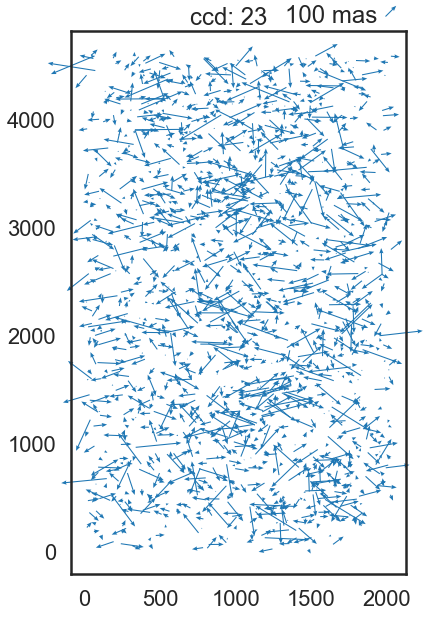

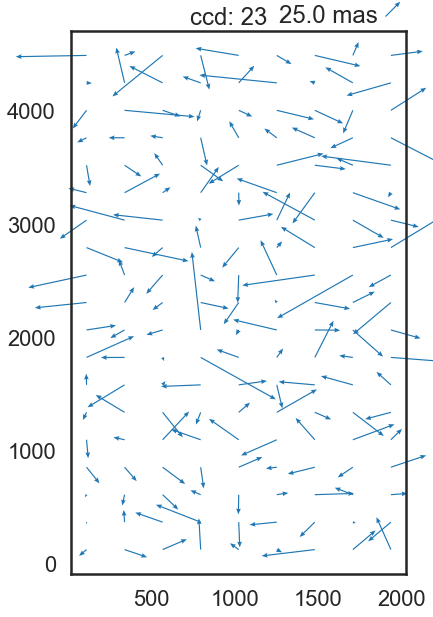

In [57]:
for ccd in ccds:
    xx, yy, uu, vv = compute_errors(counts, goodMatches, averageCoord, ccd)
    plot_quiver(xx, yy, uu, vv, ccd, 'all-jointcal')
    xMean, yMean, uMean, vMean = uv_mean(bbox, xx, yy, uu, vv)
    plot_quiver(xMean, yMean, uMean, vMean, ccd, 'mean-jointcal')